In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

%matplotlib inline

import os
import re
import json
from collections import defaultdict

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from map4 import MAP4Calculator

## Read dataset

In [2]:
mhci = pd.read_csv('../mhc/binding_data_2013/bdata.20130222.mhci.csv')

In [3]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (8 <= mhci['length']) &
            (mhci['length'] <= 11) &
            (~mhci['affinity_binding'].isin(dirty_values))]

## HELM string utils

In [4]:
def build_helm_string(polymers, connections):
    sequences_str = '|'.join(['%s{%s}' % (p, '.'.join(s)) for p, s in polymers.items()])
    if len(connections) > 0:
        connections_str = '|'.join(['%s,%s,%d:%s-%d:%s' % (c[0], c[1], c[2], c[3], c[4], c[5]) for c in connections])
    else:
        connections_str = ''
    helm_string = '%s$%s$$$V2.0' % (sequences_str, connections_str)
    
    return helm_string


def parse_helm(helm_string):
    dtype = [('SourcePolymerID', 'U20'), ('TargetPolymerID', 'U20'),
             ('SourceMonomerPosition', 'i4'), ('SourceAttachment', 'U2'),
             ('TargetMonomerPosition', 'i4'), ('TargetAttachment', 'U2')]
    
    polymers, connections, hydrogen_bonds, attributes, _ = helm_string.split('$')
    
    # Process sequences
    data = {}
    for polymer in polymers.split('|'):
        pid = polymer.split('{')[0]
        sequence = polymer[len(pid) + 1:-1].replace('.', '')
        data[pid] = sequence
        
    polymers = data
        
    # Process connections
    data = []
    if connections:
        for connection in connections.split('|'):
            source_id, target_id, con = connection.split(',')
            source_position, source_attachment = con.split('-')[0].split(':')
            target_position, target_attachment = con.split('-')[1].split(':')
            data.append((source_id, target_id,
                         source_position, source_attachment,
                         target_position, target_attachment))
        
    connections = np.array(data, dtype=dtype)
    
    return polymers, connections, hydrogen_bonds, attributes

## MHC-I peptide energy predictor

In [29]:
def read_pssm_file(pssm_file):
    data = []
    AA = []

    with open(pssm_file) as f:
        lines = f.readlines()
        
        n_columns = int(lines[0].split('\t')[1])

        for line in lines[1:-1]:
            sline = line.strip().split('\t')
            AA.append(sline[0])
            data.append([float(v) for v in sline[1:]])

    columns = list(range(1, n_columns + 1))
    pssm = pd.DataFrame(data=data, columns=columns, index=AA)
    
    return pssm


class MHCIPeptideScorer:
    
    def __init__(self, pssm_files, mhci_dataset, energy_cutoff=-5.0):
        self._pssm = {}
        self._reg = {}
        self._energy_cutoff = energy_cutoff
        
        # Read PSS matrices
        for pssm_file in pssm_files:
            pssm = read_pssm_file(pssm_file)
            self._pssm[len(pssm.columns)] = pssm
        
        # Score peptides using those PSSM
        pssm_scores = self.score(mhci_dataset['sequence'])
        
        # Fit PSSM score to experimental values
        for length in self._pssm.keys():
            selection_index = np.where(mhci_dataset.length == length)[0]
            
            reg = LinearRegression()
            reg.fit(pssm_scores[selection_index, None], mhci_dataset.iloc[selection_index].energy)
            
            print('----- Peptide length: %02d -----' % length)
            print('N peptide: %d' % selection_index.shape[0])
            print('R2: %.3f' % reg.score(pssm_scores[selection_index, None], mhci_dataset.iloc[selection_index].energy))
            print('RMSD : %.3f kcal/mol' % rmsd(reg.predict(pssm_scores[selection_index, None]), mhci_dataset.iloc[selection_index].energy))
            print('')
            
            self._reg[length] = reg
            
    def score(self, sequences):
        # Score peptides using those PSSM
        scores = []
                                 
        for sequence in sequences:
            score = 0
            
            try:
                pssm = self._pssm[len(sequence)]
            except:
                # We cannot score that peptide, so default score is 999
                score = 999
                scores.append(score)
                continue
                
            for i, aa in enumerate(sequence):
                score += pssm.loc[aa][i + 1]

            scores.append(score)

        scores = np.array(scores)
    
        return scores
            
    def predict_energy(self, sequences):
        scores = []
        
        pssm_scores = self.score(sequences)
        
        for sequence, pssm_score in zip(sequences, pssm_scores):
            try:
                reg = self._reg[len(sequence)]
            except:
                # We cannot score that peptide, so default energy is 0
                score = 0
                scores.append(score)
                continue
            
            score = reg.predict(np.array([pssm_score])[:, None])[0]
            scores.append(score)
        
        scores = np.array(scores)
        
        # Apply cutoff condition
        scores[scores > self._energy_cutoff] = 0.

        return scores
    
    def generate_random_peptides(self, n_peptides, energy_bounds, peptide_lengths):
        random_peptides = []
        random_peptide_scores = []
        
        # We don't care about which pssm we are using here
        keys = list(self._pssm.keys())
        AA = self._pssm[keys[0]].index

        while True:
            peptide_length = np.random.choice(peptide_lengths)
            
            p = ''.join(np.random.choice(AA, peptide_length))
            s = self.predict_energy([p])[0]

            if energy_bounds[0] <= s <= energy_bounds[1]:
                helm_string = build_helm_string({'PEPTIDE1': p}, [])

                random_peptides.append(helm_string)
                random_peptide_scores.append(s)
                #print(len(random_peptides))

            if len(random_peptides) == n_peptides:
                break
        
        sorted_index = np.argsort(random_peptide_scores)
        random_peptides = np.array(random_peptides)[sorted_index]
        random_peptide_scores = np.array(random_peptide_scores)[sorted_index]

        return random_peptides, random_peptide_scores

## Bayesian optimization

In [6]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood, kernel=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel is not None:
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel())
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())

        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None, kernel=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model


def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [7]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False, xi=0.00):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.
        xi: Exploitation-exploration trade-off parameter

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # calculate the expected improvement
    Z = scaling_factor * (mu - loss_optimum - xi) / (sigma + 1E-9)
    ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
    ei[sigma == 0.0] == 0.0

    return -1 * ei


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    pi = norm.cdf(Z)
    pi[sigma == 0.0] == 0.0
    
    return pi

In [8]:
class AcqScoring:
    def __init__(self, model, acq_fun, y_exp, sequence_type='fasta', greater_is_better=True):
        self._model = model
        self._acq_fun = acq_fun
        self._y_exp = y_exp
        self._sequence_type = sequence_type
        self.greater_is_better = greater_is_better
        
    def evaluate(self, sequences):
        fps = map4_fingerprint(sequences, self._sequence_type)
        return self._acq_fun(self._model, self._y_exp, fps)

In [9]:
def map4_fingerprint(molecule_strings, input_type='fasta', dimensions=4096, radius=2, is_counted=False, is_folded=True):
    f = {'fasta': Chem.rdmolfiles.MolFromFASTA,
         'smiles': Chem.rdmolfiles.MolFromSmiles,
         'helm': Chem.rdmolfiles.MolFromHELM}
    
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_counted=is_counted, is_folded=is_folded)
    try:
        fps = MAP4_unf.calculate_many([f[input_type](s) for s in molecule_strings])
    except AttributeError:
        print('Error: there are issues with the input molecules')
        print(molecule_strings)
        
    return torch.from_numpy(np.array(fps)).float()

## Genetic operators on HELM strings

In [10]:
with open('HELMCoreLibrary.json') as f:
    monomer_lib = json.load(f)

monomer_peptide_lib = [x for x in monomer_lib if x['polymerType'] == 'PEPTIDE']
AA1 = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
monomer_aa1_lib = [x for x in monomer_peptide_lib if x['symbol'] in AA1]

smiles = [monomer['smiles'] for monomer in monomer_aa1_lib]
fps = map4_fingerprint(smiles,input_type='smiles', radius=2)
t = TanimotoSimilarityKernel()
similarity_matrix = t.forward(fps, fps).numpy()

probability_matrix = []

for aa in similarity_matrix:
    tmp = aa.copy()
    tmp[tmp == 1.0] = 0
    probability_matrix.append(tmp / np.sum(tmp))
    
probability_matrix = np.array(probability_matrix)

In [11]:
class HELMGeneticOperators:
    
    def __init__(self, monomer_library, probability_matrix=None, seed=None):
        self._monomer_library = monomer_library
        self._monomer_symbols = [m['symbol'] for m in self._monomer_library]
        self._probability_matrix = probability_matrix
        
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)
        self._connections_dtype = [('SourcePolymerID', 'U20'), ('TargetPolymerID', 'U20'),
                                   ('SourceMonomerPosition', 'i4'), ('SourceAttachment', 'U2'),
                                   ('TargetMonomerPosition', 'i4'), ('TargetAttachment', 'U2')]
        
    def insert(self, helm_string, n=10, probability=0.05, only_terminus=False, maximum_size=None):
        mutant_helm_strings = []
        
        polymers, connections, _, _ = parse_helm(helm_string)
        
        # Generate mutants...
        for i in range(n):
            mutant_polymers = {}
            n_mutations = 0
        
            for pid, sequence in polymers.items():
                mutated_sequence = list(sequence)

                if only_terminus:
                    possible_positions = np.array([0, len(sequence)])
                else:
                    possible_positions = np.array(range(len(sequence)))

                # Choose positions to insert
                mutation_probabilities = self._rng.uniform(size=len(possible_positions))
                mutation_positions = possible_positions[mutation_probabilities <= probability]

                # We move to the next polymer if there is no monomer to insert...
                if len(mutation_positions) == 0:
                    mutant_polymers[pid] = (sequence, np.array([]))
                    continue

                if maximum_size is not None:
                    # In the case where mutation_positions is smaller than diff maximum_size and sequence
                    mutations_to_select = np.min([maximum_size - len(sequence), len(mutation_positions)])

                    if mutations_to_select > 0:
                        mutation_positions = self._rng.choice(mutation_positions, size=mutations_to_select, replace=False)
                    else:
                        # We move to the next polymer since the sequence length exceed already the maximum length allowed
                        mutant_polymers[pid] = (sequence, np.array([]))
                        continue

                # Since we are going to insert from the end, the array must be sorted
                mutation_positions = np.sort(mutation_positions)

                for mutation_position in mutation_positions[::-1]:
                    chosen_monomer = self._monomer_library[self._rng.choice(len(self._monomer_library))]['symbol']
                    mutated_sequence.insert(mutation_position, chosen_monomer)

                mutant_polymers[pid] = (''.join(mutated_sequence), mutation_positions)
                n_mutations += len(mutation_positions)

            if n_mutations > 0:
                data = []

                # Shift attachment positions
                for i, connection in enumerate(connections):
                    source_mutations = mutant_polymers[connection['SourcePolymerID']][1]
                    target_mutations = mutant_polymers[connection['TargetPolymerID']][1]

                    source_position = connection['SourceMonomerPosition'] + np.sum([source_mutations < connection['SourceMonomerPosition']])
                    target_position = connection['TargetMonomerPosition'] + np.sum([target_mutations < connection['TargetMonomerPosition']])

                    data.append((connection['SourcePolymerID'], connection['TargetPolymerID'], 
                                 source_position, connection['SourceAttachment'],
                                 target_position, connection['TargetAttachment']))

                new_connections = np.array(data, dtype=self._connections_dtype)

                # Reconstruct the HELM string
                mutant_helm_string = build_helm_string({p: s[0] for p, s in mutant_polymers.items()}, new_connections)

                mutant_helm_strings.append(mutant_helm_string)
            else:
                mutant_helm_strings.append(helm_string)
        
        return mutant_helm_strings
        
    def remove(self, helm_string, n=10, probability=0.05, only_terminus=False, minimun_size=None, keep_connections=True):
        mutant_helm_strings = []
        
        polymers, connections, _, _ = parse_helm(helm_string)
        
        # Generate mutants...
        for i in range(n):
            mutant_polymers = {}
            n_mutations = 0
        
            for pid, sequence in polymers.items():
                mutated_sequence = list(sequence)

                if only_terminus:
                    possible_positions = [0, len(sequence) - 1]
                else:
                    possible_positions = range(len(sequence))

                # Residues involved in a connection within and between polymers won't be removed
                if keep_connections and pid in polymers.keys():
                    connection_resids = list(connections[connections['SourcePolymerID'] == pid]['SourceMonomerPosition'])
                    connection_resids += list(connections[connections['TargetPolymerID'] == pid]['TargetMonomerPosition'])
                    # Because positions are 1-based in HELM
                    connection_resids = np.array(connection_resids) - 1
                    possible_positions = list(set(possible_positions).difference(connection_resids))

                # Choose positions to remove
                possible_positions = np.array(possible_positions)
                mutation_probabilities = self._rng.uniform(size=len(possible_positions))
                mutation_positions = possible_positions[mutation_probabilities <= probability]

                # We move to the next polymer if there is no monomer to remove...
                if len(mutation_positions) == 0:
                    mutant_polymers[pid] = (sequence, np.array([]))
                    continue

                if minimun_size is not None:
                    # In the case where mutation_positions is smaller than diff maximum_size and sequence
                    mutations_to_select = np.min([len(sequence) - minimun_size, len(mutation_positions)])

                    if mutations_to_select > 0:
                        mutation_positions = self._rng.choice(mutation_positions, size=mutations_to_select, replace=False)
                    else:
                        # We move to the next polymer since the sequence length exceed already the maximum length allowed
                        mutant_polymers[pid] = (sequence, np.array([]))
                        continue

                # Since we are going to remove from the end, the array must be sorted
                mutation_positions = np.sort(mutation_positions)

                for mutation_position in mutation_positions[::-1]:
                    mutated_sequence.pop(mutation_position)

                mutant_polymers[pid] = (''.join(mutated_sequence), mutation_positions)
                n_mutations += len(mutation_positions)

            if n_mutations > 0:
                connections_to_keep = []
                data = []

                # Check if we have to remove connections due to the monomers removed
                for i, connection in enumerate(connections):
                    # The connection positions must not be in the mutation lists
                    # mutant_polymers[connection['XXXXXPolymerID']][1] + 1 because positions are 1-based in HELM
                    if connection['SourceMonomerPosition'] not in mutant_polymers[connection['SourcePolymerID']][1] + 1 and \
                       connection['TargetMonomerPosition'] not in mutant_polymers[connection['TargetPolymerID']][1] + 1:
                        connections_to_keep.append(i)

                # Shift attachment positions (only the connections to keep)
                for i, connection in enumerate(connections[connections_to_keep]):
                    source_mutations = mutant_polymers[connection['SourcePolymerID']][1]
                    target_mutations = mutant_polymers[connection['TargetPolymerID']][1]

                    source_position = connection['SourceMonomerPosition'] - np.sum([source_mutations < connection['SourceMonomerPosition']])
                    target_position = connection['TargetMonomerPosition'] - np.sum([target_mutations < connection['TargetMonomerPosition']])

                    data.append((connection['SourcePolymerID'], connection['TargetPolymerID'], 
                                 source_position, connection['SourceAttachment'],
                                 target_position, connection['TargetAttachment']))

                new_connections = np.array(data, dtype=self._connections_dtype)

                # Reconstruct the HELM string
                mutant_helm_string = build_helm_string({p: s[0] for p, s in mutant_polymers.items()}, new_connections)

                mutant_helm_strings.append(mutant_helm_string)
            else:
                mutant_helm_strings.append(helm_string)
        
        return mutant_helm_strings

    def mutate(self, helm_string, n=10, minimum_mutations=1, maximum_mutations=None, keep_connections=True):
        mutant_helm_strings = []
        
        polymers, connections, _, _ = parse_helm(helm_string)
        
        # Generate mutants...
        for i in range(n):
            mutant_polymers = {}
            n_mutations = 0
            
            for pid, sequence in polymers.items():
                mutated_sequence = list(sequence)
                
                # Residues involved in a connection within and between peptides won't be mutated
                if keep_connections and pid in polymers.keys():
                    connection_resids = list(connections[connections['SourcePolymerID'] == pid]['SourceMonomerPosition'])
                    connection_resids += list(connections[connections['TargetPolymerID'] == pid]['TargetMonomerPosition'])
                    # Because positions are 1-based in HELM
                    connection_resids = np.array(connection_resids) - 1
                    
                    possible_positions = list(set(range(len(sequence))).difference(connection_resids))
                else:
                    possible_positions = list(range(len(sequence)))
                
                # Choose a random number of mutations between min and max
                if minimum_mutations == maximum_mutations:
                    number_mutations = maximum_mutations
                elif maximum_mutations is None:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=len(sequence))
                else:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=maximum_mutations)
                
                # Choose positions to mutate
                mutation_positions = self._rng.choice(possible_positions, size=number_mutations, replace=False)
                
                # Do mutations
                for mutation_position in mutation_positions:                    
                    monomer_symbol = mutated_sequence[mutation_position]
                    
                    # Force mutation!
                    while monomer_symbol == mutated_sequence[mutation_position]:
                        # Instead of mutating to random monomer, the selection will be
                        # based on the probability matrix
                        if self._probability_matrix is not None:
                            index_symbol = self._monomer_symbols.index(monomer_symbol)
                            p = probability_matrix[index_symbol]
                        else:
                            p = None
                        
                        chosen_monomer = self._rng.choice(self._monomer_symbols, p=p)
                        mutated_sequence[mutation_position] = chosen_monomer
                
                mutant_polymers[pid] = (mutated_sequence, mutation_positions)
                n_mutations += len(mutation_positions)
            
            if n_mutations > 0:
                if not keep_connections:
                    connections_to_keep = []

                    # Check if we have to remove connections due to the mutations
                    for i, connection in enumerate(connections):
                        # The connection positions must not be in the mutation lists
                        # mutant_polymers[connection['XXXXXPolymerID']][1] + 1 because positions are 1-based in HELM
                        if connection['SourceMonomerPosition'] not in mutant_polymers[connection['SourcePolymerID']][1] + 1 and \
                           connection['TargetMonomerPosition'] not in mutant_polymers[connection['TargetPolymerID']][1] + 1:
                            connections_to_keep.append(i)
                else:
                    connections_to_keep = list(range(connections.shape[0]))

                # Reconstruct the HELM string
                mutant_helm_string = build_helm_string({p: s[0] for p, s in mutant_polymers.items()}, connections[connections_to_keep])
                mutant_helm_strings.append(mutant_helm_string)
            else:
                mutant_helm_strings.append(helm_string)
        
        return mutant_helm_strings
            

## Playground

### Generate random peptides

In [30]:
pssm_files = ['../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-8.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-9.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-10.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-11.txt']
mps = MHCIPeptideScorer(pssm_files, mhci)

----- Peptide length: 08 -----
N peptide: 144
R2: 0.812
RMSD : 0.616 kcal/mol

----- Peptide length: 09 -----
N peptide: 5823
R2: 0.644
RMSD : 1.189 kcal/mol

----- Peptide length: 10 -----
N peptide: 2402
R2: 0.624
RMSD : 1.035 kcal/mol

----- Peptide length: 11 -----
N peptide: 102
R2: 0.849
RMSD : 0.601 kcal/mol



In [337]:
n_peptides = 150
peptide_length = [8]
energy_bounds = [-8.2, -5] # about between 1 and 250 uM
energy_cutoff = -5 # around 250 uM

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(n_peptides, energy_bounds, peptide_length)

clusters = defaultdict(list)
for i, sequence in enumerate(random_peptides):
    clusters[sequence.count('.')].append(i)
print('Distribution:', ['%d: %d' % (k, len(clusters[k])) for k in sorted(clusters.keys())])
print('')

print(random_peptides)
print(random_peptide_scores)

Distribution: ['8: 150']

['PEPTIDE1{R.V.K.V.A.G.S.S}$$$$V2.0' 'PEPTIDE1{V.L.Y.K.A.F.Q.M}$$$$V2.0'
 'PEPTIDE1{K.M.S.L.H.L.F.V}$$$$V2.0' 'PEPTIDE1{W.L.N.L.E.F.T.A}$$$$V2.0'
 'PEPTIDE1{Y.I.F.S.Y.M.W.C}$$$$V2.0' 'PEPTIDE1{M.T.G.W.N.T.K.Y}$$$$V2.0'
 'PEPTIDE1{F.H.Y.M.Y.L.L.Y}$$$$V2.0' 'PEPTIDE1{S.L.W.I.L.I.I.N}$$$$V2.0'
 'PEPTIDE1{M.I.C.I.N.L.S.Y}$$$$V2.0' 'PEPTIDE1{S.S.G.L.C.P.P.A}$$$$V2.0'
 'PEPTIDE1{D.E.V.V.I.P.M.C}$$$$V2.0' 'PEPTIDE1{A.L.A.T.V.M.C.Q}$$$$V2.0'
 'PEPTIDE1{V.L.M.V.D.G.Y.Q}$$$$V2.0' 'PEPTIDE1{L.L.Y.V.S.C.F.R}$$$$V2.0'
 'PEPTIDE1{S.L.Y.T.E.M.A.W}$$$$V2.0' 'PEPTIDE1{F.V.F.L.I.M.Y.H}$$$$V2.0'
 'PEPTIDE1{W.E.G.I.T.C.C.L}$$$$V2.0' 'PEPTIDE1{E.H.M.S.L.C.C.C}$$$$V2.0'
 'PEPTIDE1{C.F.C.I.V.F.S.V}$$$$V2.0' 'PEPTIDE1{G.M.T.A.R.D.Y.P}$$$$V2.0'
 'PEPTIDE1{Y.Q.G.R.R.P.V.G}$$$$V2.0' 'PEPTIDE1{L.T.D.R.G.P.Q.C}$$$$V2.0'
 'PEPTIDE1{Q.Y.F.L.A.D.Y.D}$$$$V2.0' 'PEPTIDE1{K.G.Y.G.E.D.D.V}$$$$V2.0'
 'PEPTIDE1{D.K.Y.T.L.W.C.Y}$$$$V2.0' 'PEPTIDE1{F.M.R.S.R.W.T.Y}$$$$V2.0'
 'PEPTIDE1{Y.T.Y.E.Q.H.L.

### Local GA optimization only

In [82]:
class LocalGAOptimization:
    
    def __init__(self, scorer, monomer_lib, probability_matrix, n_gen=3, n_children=250, sigma=0.08, greater_is_better=True):
        self._n_gen = n_gen
        self._n_children = n_children
        self._sigma = sigma
        self._greater_is_better = greater_is_better
        
        self._scorer = scorer
        self._HELMGO = HELMGeneticOperators(monomer_lib, probability_matrix=probability_matrix)
        
        self.candidates = None
        self.candidate_scores = None

    def _number_of_children_to_generate_per_parent(self, parent_scores, greater_is_better=True):
        """Compute the number of children generated by each parent sequence 
        based on their acquisition score using RBF weighting.
        """
        i = 0

        if greater_is_better == False:
            p = np.abs(parent_scores)

        # Normalize score between 0 and 1 because of the exponential
        p = (p - np.min(p)) / (np.max(p) - np.min(p))
        # RBF
        children_per_parent = self._n_children * np.exp(p**2 / (2 * self._sigma**2)) / np.sum(np.exp(p**2 / (2 * self._sigma**2)))
        children_per_parent = np.round(children_per_parent).astype(int)

        # Add 1 until the number of children is equal to n_children
        parent_indices = np.argwhere(children_per_parent > 0).flatten()

        while np.sum(children_per_parent) < self._n_children:
            try:
                if children_per_parent[parent_indices[i]] > 0:
                    children_per_parent[parent_indices[i]] += 1
                    i += 1
            except:
                # we restart from the beginning if we reach the end
                i = 0

        return children_per_parent

    def _generate_new_population(self, parents, parent_scores, greater_is_better=True):
        new_pop = []

        # Compute the number of children generated by each parent sequence based on their acquisition score
        children_per_parent = self._number_of_children_to_generate_per_parent(parent_scores, greater_is_better)

        parent_indices = np.argwhere(children_per_parent > 0).flatten()

        for i in parent_indices:
            """ If there is only one copy for that peptide, parent is replaced by the child.
            Otherwise, one child or more is generated by mutation and the parent is conserved to 
            the next generation
            """
            if children_per_parent[i] == 1:
                new_pop.extend(self._HELMGO.mutate(parents[i], n=children_per_parent[i], minimum_mutations=1, maximum_mutations=2))
            else:
                new_pop.append(parents[i])
                new_pop.extend(self._HELMGO.mutate(parents[i], n=children_per_parent[i] - 1, minimum_mutations=1, maximum_mutations=2))

        return new_pop

    def run(self, init_population, init_scores):
        self.candidates = None
        self.candidate_scores = None
        all_sequences = []
        all_sequence_scores = []

        # Generate new population
        sequences = self._generate_new_population(init_population, init_scores, False)
        # Remove duplicates
        # That is inefficient because there is a strong chance that will have less than NIND children...
        sequences = np.unique(sequences)
        # Evaluate the population
        sequence_scores = self._scorer.evaluate(sequences)

        for i in range(self._n_gen):    
            # Generate new population
            sequences = self._generate_new_population(sequences, sequence_scores, self._greater_is_better)
            # Remove duplicates
            # That is inefficient because there is a strong chance that will have less than NIND children...
            sequences = np.unique(sequences)
            # Evaluate the population
            sequence_scores = self._scorer.evaluate(sequences)

            all_sequences.extend(sequences)
            all_sequence_scores.extend(np.ravel(sequence_scores))

        # Remove duplicates
        all_sequences, unique_indices = np.unique(all_sequences, return_index=True)
        all_sequence_scores = np.array(all_sequence_scores)[unique_indices]
        
        # Sort candidates by scores in the decreasing order (best to worst)
        if self._greater_is_better:
            sorted_indices = np.argsort(all_sequence_scores)[::-1]
        else:
            sorted_indices = np.argsort(all_sequence_scores)
        
        self.candidates = all_sequences[sorted_indices]
        self.candidate_scores = all_sequence_scores[sorted_indices]


Run: 1
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.145
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 005
N pep under -7 kcal/mol: 043
N pep under -6 kcal/mol: 102
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1
[53 34 31 31 19 16 14 13 12  6  5  3  3  3  3  1  1  1  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
[53 34 31 31 18 15 13 12 11  5  4  2  2  2  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0

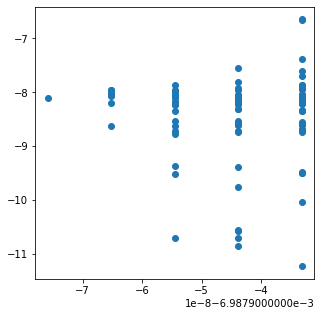




Generation: 2
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  21   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  35   0  12   0   0  20   0   0   0   0   0   0  12   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0 148   0   0   0   0   0
   0   0   0   0   0   0   0   0  

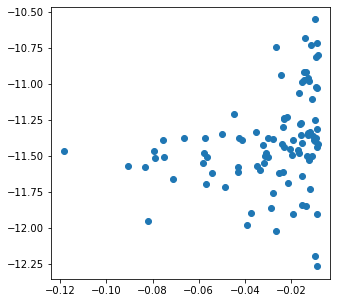




Generation: 3
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  2  3  3  9  2  3  2  3  4  2  3  2  2  4  3  3  2  4
  0  3  3  2  2 10  8  2  3  3  2  3  3  2  3  2  7  5  2  0 11  3  0  2
  3  2  0  0  2  0  4  2  2  8  2  1  0  1  1  1  1  0  5  1  3  0  0  0
  6  0  2  0  1  1  0  2  1  4  0 

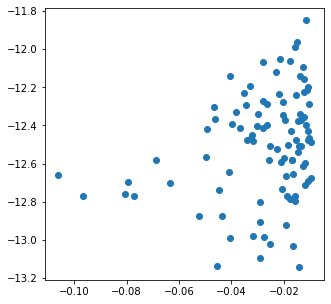




Run: 2
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.145
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 005
N pep under -7 kcal/mol: 043
N pep under -6 kcal/mol: 102
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1
[53 34 31 31 19 16 14 13 12  6  5  3  3  3  3  1  1  1  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
[53 34 31 31 18 15 13 12 11  5  4  2  2  2  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0

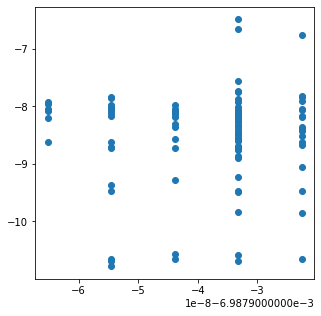




Generation: 2
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 50 30  0  0  0  0  0  0  0  0  0
  0  0  0  0 33 20  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0
  0  0  0 33 22  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  0  0  0 29]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  

KeyboardInterrupt: 

In [177]:
custom_candidate_fps = []
custom_candidate_y = []

NGEN = 3
NIND = 250
NCAN = 96
SIGMA = 0.2

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # We want to keep a copy of the random peptides generated
    candidates = random_peptides.copy()
    candidate_scores = random_peptide_scores.copy()
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(candidates, input_type='helm')
    y_exp = torch.from_numpy(candidate_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n\n')
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-13, -12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))
    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))

        # Fit GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)
        
        # Find new candidates (local GA optimization)
        #acq = AcqScoring(model, probability_of_improvement, y_exp, sequence_type='helm')
        acq = AcqScoring(model, expected_improvement, y_exp, sequence_type='helm')
        lgao = LocalGAOptimization(acq, monomer_aa1_lib, probability_matrix, NGEN, NIND, SIGMA, greater_is_better=False)
        lgao.run(candidates, candidate_scores)
        
        # Take NCAN (96) best candidates found
        candidate_sequences = lgao.candidates[:NCAN]
        candidates_acq = lgao.candidate_scores[:NCAN]
        
        # Get affinitiy binding values (MAKE TEST)
        candidate_sequences_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in candidate_sequences]
        y_candidates = mps.predict_energy(candidate_sequences_fasta)
        
        # Add candidates to the training set
        candidates = np.append(candidates, candidate_sequences)
        candidate_scores = np.append(candidate_scores, y_candidates)
        candidate_fps = map4_fingerprint(candidate_sequences, input_type='helm')

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, torch.from_numpy(y_candidates)])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-13, -12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates)
        plt.show()
        print('\n\n')
    
    custom_candidate_fps.append(X_fps_exp.detach().numpy())
    custom_candidate_y.append(y_exp.detach().numpy())

custom_candidate_fps = np.array(custom_candidate_fps)
custom_candidate_y = np.array(custom_candidate_y)


### Global + local GA optimization

In [14]:
def _number_of_children_to_generate_per_parent(parent_scores, n_children, sigma, elitism=False, greater_is_better=True):
    """Compute the number of children generated by each parent sequence 
    based on their acquisition score using RBF weighting.
    """
    i = 0
    
    # Handle case when there is only one parent
    if len(parent_scores) == 1:
        children_per_parent = np.array([n_children])
        
        if elitism:
            children_per_parent -= 1
        
        return children_per_parent

    if greater_is_better == False:
        parent_scores = np.abs(parent_scores)

    # Normalize score between 0 and 1 because of the exponential
    p = (parent_scores - np.min(parent_scores)) / (np.max(parent_scores) - np.min(parent_scores))
    # RBF weighting
    children_per_parent = n_children * np.exp(p**2 / (2 * sigma**2)) / np.sum(np.exp(p**2 / (2 * sigma**2)))
    children_per_parent = np.floor(children_per_parent).astype(int)
    
    if elitism:
        # All the parents with less than two children are disqualified in elistism mode
        # because we will need to substract 1 at the end
        children_per_parent[children_per_parent < 2] = 0
    
    parent_indices = np.argwhere(children_per_parent > 0).flatten()
    
    if np.sum(children_per_parent) == 0:
        print(len(parent_scores), np.sum(children_per_parent), n_children)
        print(parent_scores)
        print(p)
    
    # Add 1 until the number of children is equal to n_children
    while np.sum(children_per_parent) < n_children:
        try:
            if children_per_parent[parent_indices[i]] > 0:
                children_per_parent[parent_indices[i]] += 1
            i += 1
        except:
            # we restart from the beginning if we reach the end
            i = 0
    
    if elitism:
        # Here we substract 1 in order to take account of the parent that we keep
        children_per_parent[children_per_parent > 1] -= 1

    return children_per_parent

In [35]:
class LocalGAOptimization:
    
    def __init__(self, monomer_lib, probability_matrix, n_gen=3, n_children=250, sigma=0.08):
        self.candidates = None
        self.candidate_scores = None
        self._n_gen = n_gen
        self._n_children = n_children
        self._sigma = sigma
        
        self._HELMGO = HELMGeneticOperators(monomer_lib, probability_matrix=probability_matrix)

    def _generate_new_population(self, parents, parent_scores, greater_is_better=True):
        new_pop = []
        elitism = True

        # Compute the number of children generated by each parent sequence based on their acquisition score
        children_per_parent = _number_of_children_to_generate_per_parent(parent_scores, self._n_children, self._sigma, elitism, greater_is_better)

        parent_indices = np.argwhere(children_per_parent > 0).flatten()

        for i in parent_indices:
            if elitism:
                new_pop.append(parents[i])
            
            new_pop.extend(self._HELMGO.mutate(parents[i], n=children_per_parent[i], minimum_mutations=1, maximum_mutations=2))

        return new_pop

    def run(self, scorer, sequences):
        self.candidates = None
        self.candidate_scores = None
        all_sequences = []
        all_sequence_scores = []
        
        # Evaluate the initial population
        sequence_scores = scorer.evaluate(sequences)

        for i in range(self._n_gen):
            # Generate new population
            sequences = self._generate_new_population(sequences, sequence_scores, scorer.greater_is_better)
            # Remove duplicates
            # That is inefficient because there is a strong chance that will have less than NIND children...
            sequences = np.unique(sequences)
            # Evaluate the population
            sequence_scores = scorer.evaluate(sequences)

            all_sequences.extend(sequences)
            all_sequence_scores.extend(np.ravel(sequence_scores))

        # Remove duplicates
        all_sequences, unique_indices = np.unique(all_sequences, return_index=True)
        all_sequence_scores = np.array(all_sequence_scores)[unique_indices]
        
        # Sort candidates by scores in the decreasing order (best to worst)
        if scorer.greater_is_better:
            sorted_indices = np.argsort(all_sequence_scores)[::-1]
        else:
            sorted_indices = np.argsort(all_sequence_scores)
        
        self.candidates = all_sequences[sorted_indices]
        self.candidate_scores = all_sequence_scores[sorted_indices]
        
        print('End local opt - Score: %5.3f - Seq: %d - %s' % (self.candidate_scores[0], self.candidates[0].count('.'), self.candidates[0]))


In [36]:
class GAOptimization:
    
    def __init__(self, lgao, monomer_lib, probability_matrix, n_gen=1, n_children=1000, sigma=0.4):
        self.candidates = None
        self.candidate_scores = None
        self._n_gen = n_gen
        self._n_children = n_children
        self._sigma = sigma
        
        self._HELMGO = HELMGeneticOperators(monomer_lib, probability_matrix=probability_matrix)
        # Local GA optimization
        self._lgao = lgao
        
    def _generate_new_population(self, parents, parent_scores, elitism=True, greater_is_better=True):
        new_pop = []
        probability = 0.5
        only_terminus = True
        minimum_size = 8
        maximum_size = 11
        
        # Compute the number of children generated by each parent sequence based on their acquisition score
        children_per_parent = _number_of_children_to_generate_per_parent(parent_scores, self._n_children, self._sigma, elitism, greater_is_better)

        parent_indices = np.argwhere(children_per_parent > 0).flatten()
        
        for i in parent_indices:
            tmp = []
            
            if elitism:
                new_pop.append(parents[i])
            
            actions = np.random.choice(['insert', 'remove'], size=children_per_parent[i])
            
            tmp.extend(self._HELMGO.insert(parents[i], np.sum(actions == "insert"), probability, only_terminus, maximum_size))
            tmp.extend(self._HELMGO.remove(parents[i], np.sum(actions == "remove"), probability, only_terminus, minimum_size))
            tmp = [self._HELMGO.mutate(t, n=1, minimum_mutations=1, maximum_mutations=2)[0] for t in tmp]
            
            """
            print(parents[i].count('.'), children_per_parent[i], parents[i])
            clusters = defaultdict(list)
            for i, sequence in enumerate(tmp):
                clusters[sequence.count('.')].append(i)
            print('Distribution:', ['%d: %d' % (k, len(clusters[k])) for k in sorted(clusters.keys())])
            print('')
            """
            
            new_pop.extend(tmp)

        return new_pop
    
    def run(self, scorer, init_population, init_scores):
        self.candidates = None
        self.candidate_scores = None
        all_sequences = []
        all_sequence_scores = []

        for i in range(self._n_gen):
            tmp_sequences = []
            tmp_scores = []
            
            # Generate new population
            if i == 0:
                # During the first step, the new population will be generated based on peptides with exp. values
                sequences = self._generate_new_population(init_population, init_scores, False, False)
            else:
                sequences = self._generate_new_population(sequences, sequence_scores, True, scorer.greater_is_better)
            
            # Remove duplicates
            sequences = np.unique(sequences)
            
            # Clustering peptides based on the length
            clusters = defaultdict(list)
            for i, sequence in enumerate(sequences):
                clusters[sequence.count('.')].append(i)
            
            # Dispatch peptides and run local GA opt.
            for length_sequence, sequence_indices in clusters.items():
                self._lgao.run(scorer, sequences[sequence_indices])
                tmp_sequences.extend(self._lgao.candidates)
                tmp_scores.extend(self._lgao.candidate_scores)
            
            sequences = tmp_sequences
            sequence_scores = tmp_scores
            all_sequences.extend(sequences)
            all_sequence_scores.extend(np.ravel(sequence_scores))

        # Remove duplicates
        all_sequences, unique_indices = np.unique(all_sequences, return_index=True)
        all_sequence_scores = np.array(all_sequence_scores)[unique_indices]
        
        # Sort candidates by scores in the decreasing order (best to worst)
        if scorer.greater_is_better:
            sorted_indices = np.argsort(all_sequence_scores)[::-1]
        else:
            sorted_indices = np.argsort(all_sequence_scores)
        
        self.candidates = all_sequences[sorted_indices]
        self.candidate_scores = all_sequence_scores[sorted_indices]
        
        print('End global opt - Score: %5.3f - Seq: %d - %s' % (self.candidate_scores[0], self.candidates[0].count('.'), self.candidates[0]))


In [310]:
class DMTExperience:
    
    def __init__(self, init_population, init_scores):
        self._init_pop = init_population
        self._init_scores = init_scores
        
    def run(self, n_gen=3, n_sample=10, **config):        
        data = []
        NCAN = config['NCAN']

        # Defined local and global GA optimization
        lgao = LocalGAOptimization(config['monomer_aa1_lib'], config['probability_matrix'],
                                   n_gen=config['local_n_gen'], n_children=config['local_n_children'],
                                   sigma=config['local_sigma'])

        gao = GAOptimization(lgao, config['monomer_aa1_lib'], config['probability_matrix'],
                             n_gen=config['global_n_gen'], n_children=config['global_n_children'],
                             sigma=config['global_sigma'])
        
        # Add initial data
        for seq, exp_score in zip(self._init_pop, self._init_scores):
            data.append((0, 0, exp_score, np.nan, seq.count('.'), seq))

        for i in range(n_sample):
            print('Run: %s' % (i + 1))

            # We want to keep a copy of the random peptides generated
            candidates = self._init_pop.copy()
            candidate_scores = self._init_scores.copy()

            # Compute the MAP4 fingerprint for all the peptides
            X_fps_exp = map4_fingerprint(candidates, input_type='helm')
            y_exp = torch.from_numpy(candidate_scores).float()
            print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))

            print('\n')
            print('Init.')
            print('N pep: ', X_fps_exp.shape[0])
            print('Best peptide: %.3f' % y_exp.min())
            for n in [-13, -12, -11, -10, -9, -8, -7, -6, -5]:
                print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
            print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))
            print('\n')

            for j in range(n_gen):
                print('Generation: %d' % (j + 1))

                # Fit GP model
                model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

                # Initialize acquisition function
                #acq = AcqScoring(model, probability_of_improvement, y_exp, sequence_type='helm')
                acq = AcqScoring(model, expected_improvement, y_exp, sequence_type='helm', greater_is_better=False)

                # Find new candidates using GA optimization
                gao.run(acq, candidates, candidate_scores)

                # Take NCAN (96) best candidates found
                candidate_sequences = gao.candidates[:NCAN]
                candidates_acq = gao.candidate_scores[:NCAN]

                clusters = defaultdict(list)
                for i_seq, sequence in enumerate(candidate_sequences):
                    clusters[sequence.count('.')].append(i_seq)
                print('Final selection:', ['%d: %d' % (k, len(v)) for k, v in clusters.items()])

                # Get affinitiy binding values (MAKE TEST)
                candidate_sequences_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in candidate_sequences]
                y_candidates = mps.predict_energy(candidate_sequences_fasta)

                # Add candidates to the training set
                candidates = np.append(candidates, candidate_sequences)
                candidate_scores = np.append(candidate_scores, y_candidates)
                candidate_fps = map4_fingerprint(candidate_sequences, input_type='helm')

                X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
                y_exp = torch.cat([y_exp, torch.from_numpy(y_candidates)])
                
                print('')
                print('N pep: ', X_fps_exp.shape[0])
                print('Best peptide: %.3f' % y_exp.min())
                for n in [-13, -12, -11, -10, -9, -8,  -7, -6, -5]:
                    print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
                print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))
                print('')
                
                # Store data
                for seq, acq_score, exp_score in zip(candidate_sequences, candidates_acq, y_candidates):
                    data.append((i + 1, j + 1, exp_score, acq_score, seq.count('.'), seq))
        
        columns = ['sample', 'gen', 'exp_score', 'acq_score', 'length', 'sequence']
        df = pd.DataFrame(data=data, columns=columns)
        
        return df


In [340]:
config = {'NCAN': 96,
          'monomer_aa1_lib': monomer_aa1_lib, 'probability_matrix': probability_matrix,
          'local_n_gen': 3, 'local_n_children': 250, 'local_sigma': 0.08,
          'global_n_gen': 1, 'global_n_children': 1000, 'global_sigma': 0.2}

dmt = DMTExperience(random_peptides, random_peptide_scores)
df = dmt.run(4, 10, **config)

Run: 1
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.166
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
N pep under -7 kcal/mol: 037
N pep under -6 kcal/mol: 091
N pep under -5 kcal/mol: 150
Non binding pep        : 000


Generation: 1
End local opt - Score: -0.079 - Seq: 10 - PEPTIDE1{P.V.L.G.L.C.M.P.L.Y}$$$$V2.0
End local opt - Score: -0.723 - Seq: 8 - PEPTIDE1{L.M.F.L.A.L.Y.V}$$$$V2.0
End local opt - Score: -0.279 - Seq: 9 - PEPTIDE1{M.M.L.Y.L.A.F.L.C}$$$$V2.0
End global opt - Score: -0.723 - Seq: 8 - PEPTIDE1{L.M.F.L.A.L.Y.V}$$$$V2.0
Final selection: ['8: 96']

N pep:  246
Best peptide: -11.338
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 044
N pep under -8 kcal/mol: 097
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 187
N pep 

End local opt - Score: -0.108 - Seq: 8 - PEPTIDE1{L.L.A.L.A.L.Y.S}$$$$V2.0
End local opt - Score: -0.000 - Seq: 9 - PEPTIDE1{L.L.A.A.A.L.Y.S.C}$$$$V2.0
End local opt - Score: -0.000 - Seq: 10 - PEPTIDE1{P.P.L.L.L.A.L.Y.S.S}$$$$V2.0
End global opt - Score: -0.108 - Seq: 8 - PEPTIDE1{L.L.A.L.A.L.Y.S}$$$$V2.0
Final selection: ['8: 96']

N pep:  438
Best peptide: -13.055
N pep under -13 kcal/mol: 001
N pep under -12 kcal/mol: 112
N pep under -11 kcal/mol: 170
N pep under -10 kcal/mol: 183
N pep under -9 kcal/mol: 229
N pep under -8 kcal/mol: 287
N pep under -7 kcal/mol: 325
N pep under -6 kcal/mol: 379
N pep under -5 kcal/mol: 438
Non binding pep        : 000

Generation: 4
End local opt - Score: -0.080 - Seq: 8 - PEPTIDE1{L.L.A.V.V.L.Y.S}$$$$V2.0
End local opt - Score: -0.000 - Seq: 10 - PEPTIDE1{G.P.L.A.A.L.L.Y.S.S}$$$$V2.0
End local opt - Score: -0.000 - Seq: 9 - PEPTIDE1{G.P.L.A.L.L.L.Y.S}$$$$V2.0
End global opt - Score: -0.080 - Seq: 8 - PEPTIDE1{L.L.A.V.V.L.Y.S}$$$$V2.0
Final selecti


N pep:  246
Best peptide: -10.801
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 008
N pep under -8 kcal/mol: 073
N pep under -7 kcal/mol: 131
N pep under -6 kcal/mol: 187
N pep under -5 kcal/mol: 246
Non binding pep        : 000

Generation: 2
End local opt - Score: -0.027 - Seq: 9 - PEPTIDE1{L.L.L.Y.L.A.L.Y.S}$$$$V2.0
End local opt - Score: -0.001 - Seq: 10 - PEPTIDE1{L.L.M.Y.L.A.L.Y.S.S}$$$$V2.0
End local opt - Score: -0.268 - Seq: 8 - PEPTIDE1{L.M.Y.L.A.L.Y.S}$$$$V2.0
End global opt - Score: -0.268 - Seq: 8 - PEPTIDE1{L.M.Y.L.A.L.Y.S}$$$$V2.0
Final selection: ['8: 76', '9: 20']

N pep:  342
Best peptide: -12.318
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 052
N pep under -10 kcal/mol: 078
N pep under -9 kcal/mol: 091
N pep under -8 kcal/mol: 165
N pep under -7 kcal/mol: 225
N pep under -6 kcal/mol: 282
N pep under -5 kcal/mol: 342
Non binding 


N pep:  534
Best peptide: -13.064
N pep under -13 kcal/mol: 023
N pep under -12 kcal/mol: 211
N pep under -11 kcal/mol: 277
N pep under -10 kcal/mol: 288
N pep under -9 kcal/mol: 323
N pep under -8 kcal/mol: 383
N pep under -7 kcal/mol: 421
N pep under -6 kcal/mol: 475
N pep under -5 kcal/mol: 534
Non binding pep        : 000

Run: 9
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.166
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
N pep under -7 kcal/mol: 037
N pep under -6 kcal/mol: 091
N pep under -5 kcal/mol: 150
Non binding pep        : 000


Generation: 1
End local opt - Score: -0.609 - Seq: 8 - PEPTIDE1{L.M.F.L.S.L.Y.V}$$$$V2.0
End local opt - Score: -0.353 - Seq: 9 - PEPTIDE1{L.Y.M.Y.L.F.L.F.C}$$$$V2.0
End local opt - Score: -0.144 - Seq: 10 - PEPTIDE1{L.L.L.Y.L.A.F.F.M.C}$$$$V2.0
End global opt - Score: -0.609 - Seq: 8 - PEPTIDE1

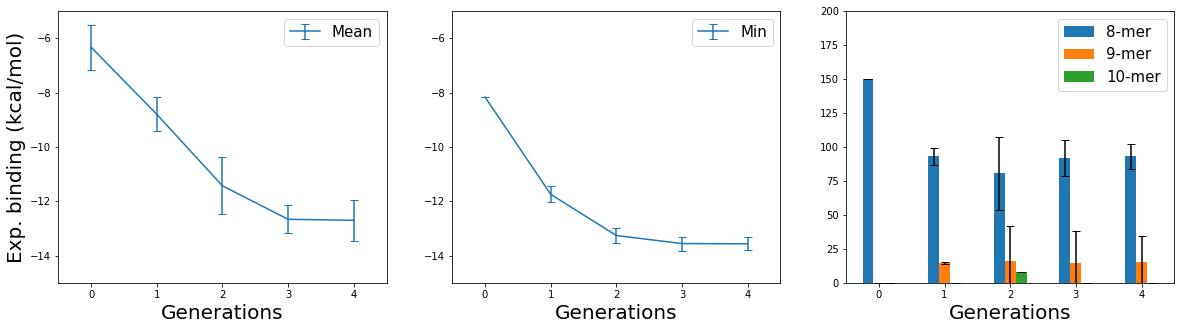

In [341]:
fig, axarr = plt.subplots(1, 3, sharex=True, figsize=(20, 5))

# Average
df.groupby(by=['gen'])['exp_score']\
  .agg(['mean', 'std'])\
  .reset_index()\
  .plot(x='gen', y='mean', yerr='std', ax=axarr[0], capsize=4, rot=0, fontsize=10)

# Min
y = df.groupby(by=['gen'])['exp_score']\
  .agg(['min'])\
  .reset_index()

errors = df.groupby(by=['sample', 'gen'])['exp_score']\
  .agg(['min'])\
  .reset_index()\
  .groupby(by=['gen'])['min']\
  .agg(['std'])\
  .fillna(0)\
  .reset_index()

y.plot(x='gen', yerr=errors['std'], ax=axarr[1], capsize=4, rot=0, fontsize=10)

# Length
y = df.groupby(by=['sample', 'gen', 'length'])\
  .agg(['count'])['exp_score']\
  .groupby(['gen', 'length'])\
  .mean()\
  .fillna(0)\
  .pivot_table(['count'], ['gen'], 'length')\
  .reset_index()\
  .fillna(0)

# fillna(0) to avoid NaN otherwise removed when pivoting...
errors = df.groupby(by=['sample', 'gen', 'length'])\
  .agg(['count'])['exp_score']\
  .groupby(['gen', 'length'])\
  .std()\
  .fillna(0)\
  .pivot_table(['count'], ['gen'], 'length')\
  .reset_index()\
  .fillna(0)

y.plot.bar(x='gen', yerr=errors, ax=axarr[2], capsize=4, rot=0, fontsize=10)

axarr[0].set_xlabel('Generations', fontsize=20)
axarr[1].set_xlabel('Generations', fontsize=20)
axarr[2].set_xlabel('Generations', fontsize=20)
axarr[0].set_ylabel('Exp. binding (kcal/mol)', fontsize=20)

axarr[0].set_ylim([-15, -5])
axarr[1].set_ylim([-15, -5])
axarr[2].set_ylim([0, 200])

axarr[0].legend(['Mean'], fontsize=15)
axarr[1].legend(['Min'], fontsize=15)
axarr[2].legend(['%d-mer' % s for s in np.sort(df['length'].unique())], fontsize=15)

run_name = '8-mers_G4-1000-0.2_L3-250-0.08_8-9-10-11-mers_3' 
df.to_csv('data_%s.csv' % run_name, index=False)
plt.savefig('figure_%s.png' % run_name, dpi=300, bbox_inches='tight')
plt.show()